**Часть 2. Тематическое моделирование**

**1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.**

In [ ]:
import json

import bz2
import regex as re
from tqdm import tqdm
from scipy import sparse

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:18, 2559.90it/s]


In [ ]:
responses[:1]

[{'city': 'г. Москва',
  'rating_not_checked': False,
  'title': 'Жалоба',
  'num_comments': 0,
  'bank_license': 'лицензия № 2562',
  'author': 'uhnov1',
  'bank_name': 'Бинбанк',
  'datetime': '2015-06-08 12:50:54',
  'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом 

Предварительная обработка текста.

In [ ]:
def cleaning(response):

  resp_ = re.sub(r'http\S+', '', response) # удаление ссылок
  resp_ = re.sub('-', ' ', resp_) # замена дефисов на пробелы
  resp_ = resp_.lower() # приведение к нижнему регистру
  resp_ = re.sub('\s+', ' ', resp_) # удаление лишних пробельных символов
  resp_ = re.sub('[^а-яёА-Я-Ё\s]', '', resp_) # удаление всего, что не является токенами из кириллических букв, в т.ч. знаков пунктуации

  return resp_

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

In [ ]:
# Список текстов отзывов, к которым применена функция cleaning и из которых удалены стоп-слова:
clean_responses = []

for el in tqdm(responses):
    clean_resp = cleaning(el['text']) # применение фнкции cleaning
    clean_responses.append(remove_stopwords(clean_resp, stopwords=stop_words)) # удаление стоп-слов на русском и добавление отзыва в список

100%|██████████| 153499/153499 [01:46<00:00, 1444.39it/s]


Лемматизацию выполним с помощью библиотеки pymystem3.

In [ ]:
!pip install pymystem3

In [ ]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
resp_lem = []
for el in tqdm(clean_responses):
  lem_temp = mystem_analyzer.lemmatize(el)
  resp_lem.append(''.join(lem_temp))

100%|██████████| 153499/153499 [17:05<00:00, 149.68it/s]


In [ ]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [ ]:
texts = [text.split() for text in tqdm(resp_lem)]
dictionary = Dictionary(texts)

100%|██████████| 153499/153499 [00:05<00:00, 27848.49it/s]


In [ ]:
corpus = [dictionary.doc2bow(text) for text in tqdm(texts)]
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

100%|██████████| 153499/153499 [00:19<00:00, 7710.03it/s] 


In [ ]:
from gensim.models import lsimodel, ldamodel

Модель LSI.

In [ ]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10, random_seed=42)

CPU times: user 1min 58s, sys: 11.5 s, total: 2min 10s
Wall time: 1min 40s


In [ ]:
topics_lsi = lsi.show_topics(num_topics=10, num_words=10, formatted= False)
topics_lsi[1]

(1,
 [('вклад', -0.49296475661287587),
  ('кредит', 0.31222245030553925),
  ('платеж', 0.16187448937769966),
  ('открывать', -0.15380895558781557),
  ('задолженность', 0.14893340962963075),
  ('страховка', 0.1350553459261084),
  ('погашение', 0.13257478068560521),
  ('очередь', -0.13179113158582886),
  ('банкомат', -0.1312009176354601),
  ('карта', -0.10724376942213588)])

Визуализируем первые пять полученных наборов тем с помощью "Облака слов".

In [ ]:
from wordcloud import WordCloud

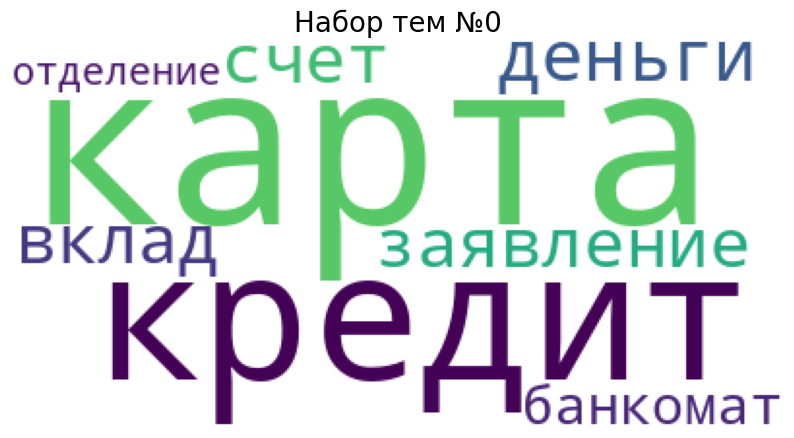

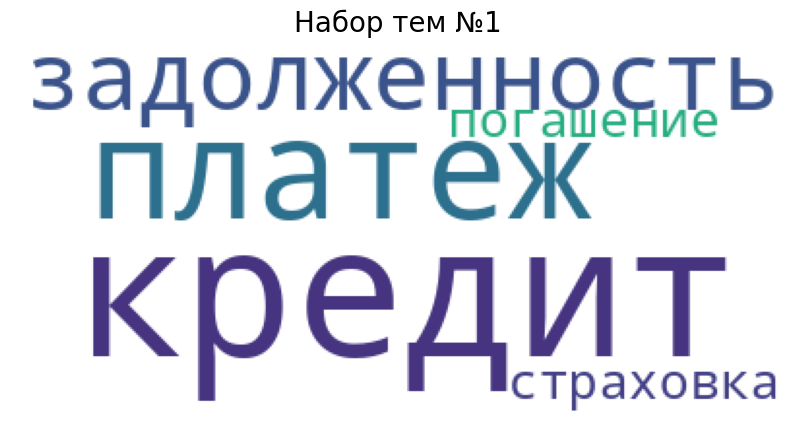

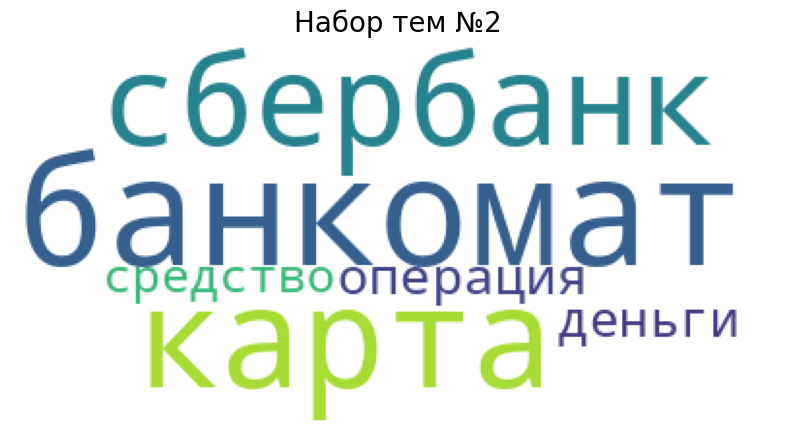

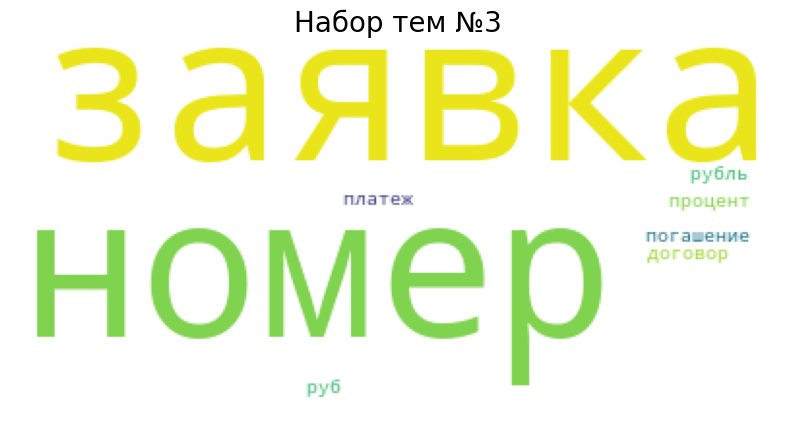

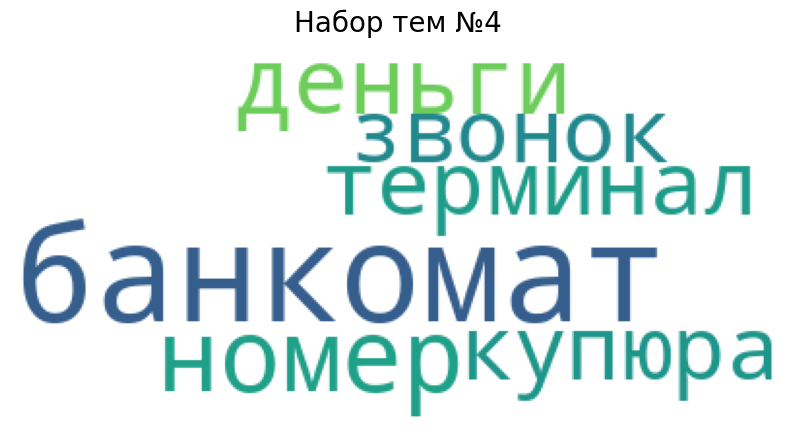

In [ ]:
for num in range(lsi.num_topics-5):
  plt.figure(figsize=(10, 7))
  plt.imshow(WordCloud(background_color="white", max_words=8, collocations=False).fit_words(dict(topics_lsi[num][1])))
  plt.title(f'Набор тем №{num}', fontsize=20)
  plt.axis('off')
  plt.show()

Модель LDA.

In [ ]:
#dictionary.filter_extremes(no_below=3, no_above=0.3)
#dictionary.compactify()
len(dictionary)

109001

In [ ]:
%%time
lda = ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, eval_every=20, num_topics=10, passes=5, random_state=42)

CPU times: user 10min 12s, sys: 7.51 s, total: 10min 19s
Wall time: 10min 21s


In [ ]:
topics_lda = lda.show_topics(num_words=10, formatted= False)
topics_lda[:2]

[(0,
  [('юниаструм', 0.010530285),
   ('обменник', 0.004241538),
   ('дельта', 0.0042173327),
   ('комитет', 0.003899881),
   ('солидный', 0.0036989679),
   ('судьба', 0.0036385702),
   ('питерский', 0.003452387),
   ('авангард', 0.003341247),
   ('дешево', 0.0031524745),
   ('обходиться', 0.0031455685)]),
 (1,
  [('авангард', 0.008519848),
   ('ситифон', 0.007948937),
   ('очередь', 0.005428219),
   ('охранник', 0.0054233307),
   ('стойка', 0.0053262482),
   ('порадовать', 0.004708255),
   ('ренессанс', 0.004329781),
   ('стол', 0.0038735627),
   ('обед', 0.003776384),
   ('рбр', 0.0035757145)])]

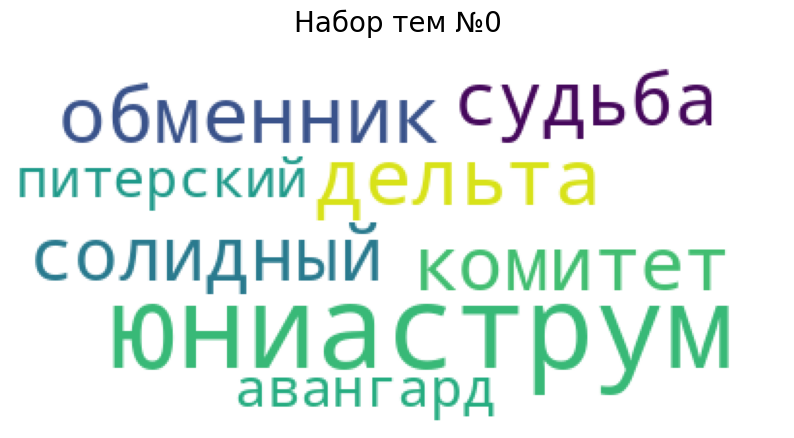

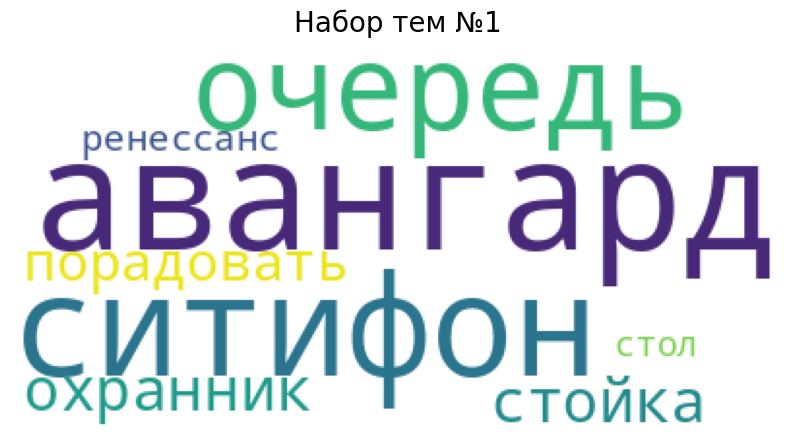

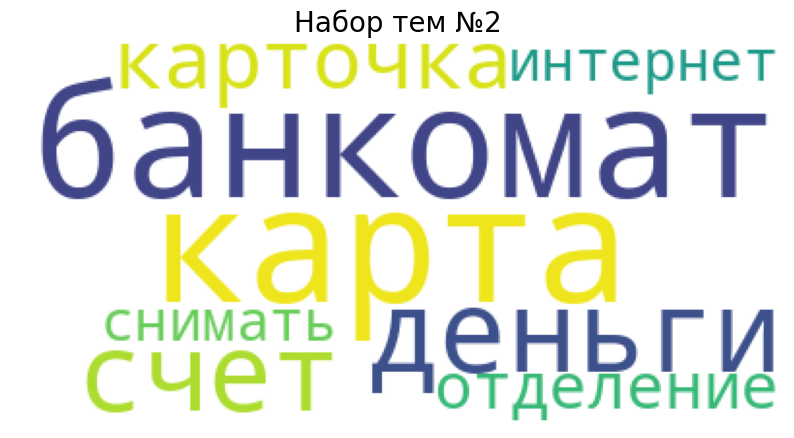

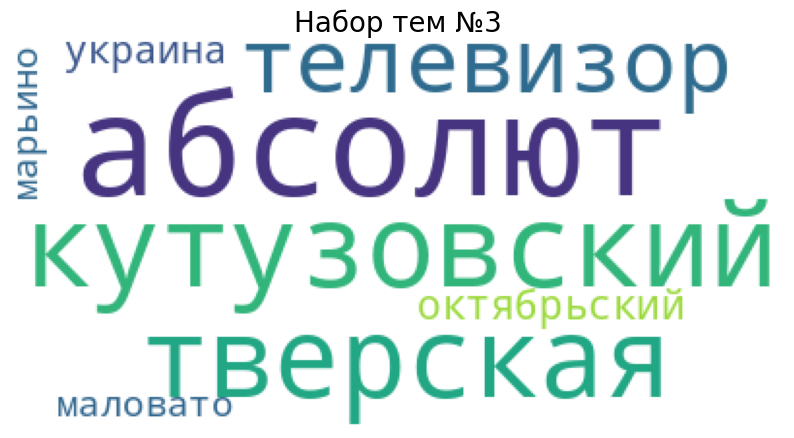

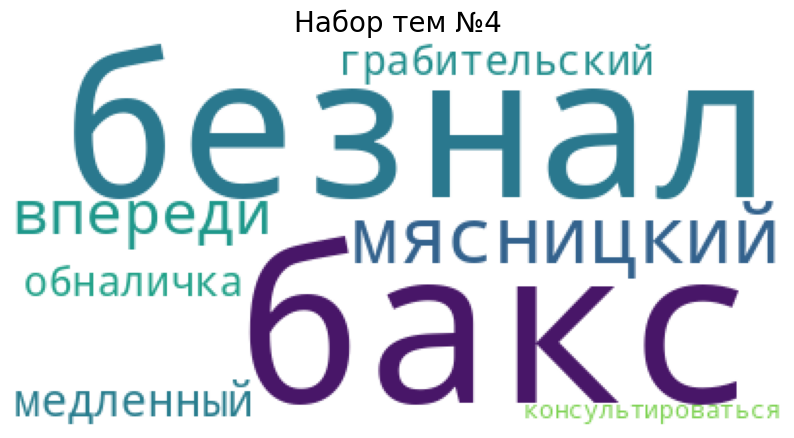

In [ ]:
for num in range(lda.num_topics-5):
  plt.figure(figsize=(10, 7))
  plt.imshow(WordCloud(background_color="white", max_words=8, collocations=False).fit_words(dict(topics_lda[num][1])))
  plt.title(f'Набор тем №{num}', fontsize=20)
  plt.axis('off')
  plt.show()

Модель NMF (библиотека sklearn).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
resp_lem[:1]

['добрый день являться клиент банк поручитель кредитный договор также являться какой либо другой лицо письменно оформлять отношение банк повод урегулирование чей либо задолженность начинать марта год начинать приходить бесконечный письмо ооо примо коллектный адрес город москва уваровский переулок дом квартира угроза возбуждение уголовный дело отношение гражданин филиппов эдуард владимирович который уклоняться уплата взять кредит договор год договор год весь ответственность хотеть заверять вышеуказанный гражданин который разыскивать знакомый мой адрес зарегистрировать какой образ удостоверяться подлинность документ оформлять имя кредитный договор меньший мера понятно почему ваш милость должный переживать бояться свой имущество письмо доставлять серьезный неудобство нарушать мой гражданский право также нарушать закон защита персональный данные убедительно просить прекращать посылать адрес письмо угроза вопрос который иметь отношение случай отклонение мой претензия быть вынужденный обраща

In [ ]:
%%time
# Для разнообразия будем использовать биграммы:
vect = TfidfVectorizer(ngram_range=(2, 2), analyzer='word', tokenizer=word_tokenize, stop_words=stop_words)
texts_tfidf = vect.fit_transform(resp_lem)

CPU times: user 3min 6s, sys: 3.58 s, total: 3min 9s
Wall time: 3min 14s


In [ ]:
%%time
nmf = NMF(n_components=10, random_state=42)
nmf.fit(texts_tfidf)

CPU times: user 6min 11s, sys: 50.1 s, total: 7min 1s
Wall time: 7min


NMF(n_components=10, random_state=42)

In [ ]:
topics_nmf = vect.get_feature_names_out()
topics_nmf

array(['аа ааа', 'аа абсолютно', 'аа август', ..., 'ёх месяц',
       'ёх неделя', 'ёх посмотреть'], dtype=object)

In [ ]:
for topic_idx, topic_words in enumerate(nmf.components_):
    top_words_idx = topic_words.argsort()[-10:][::-1]
    top_words = [topics_nmf[i] for i in top_words_idx]
    print(f"Тема №{topic_idx + 1}: {', '.join(top_words)}")

Тема №1: написать заявление, горячий линия, служба поддержка, деньги карта, снимать деньги, отделение банк, деньги счет, срок рассмотрение, рабочий день, писать заявление
Тема №2: ваш банк, номер телефон, клиент ваш, ваш сотрудник, поступать звонок, являться клиент, добрый день, кредит ваш, сотрудник ваш, звонок ваш
Тема №3: денежный средство, средство счет, сбербанк россия, возврат денежный, средство размер, банковский карта, оао сбербанк, перевод денежный, средство карта, списание денежный
Тема №4: согласие обработка, персональный данные, обработка свой, свой персональный, требовать удалять, поэтому требовать, отношение обязательство, копия жалоба, иметь отношение, база обзвон
Тема №5: альфа банк, клиент альфа, сотрудник альфа, карта альфа, оао альфа, отделение альфа, альфа клик, альфа банка, банкомат альфа, кредит альфа
Тема №6: кредитный карта, кредитный лимит, кредитный история, карта банк, оформлять кредитный, льготный период, годовой обслуживание, дебетовый карта, заявление закр

Примеры интерпретируемых тем.

1) Модель LSI:
  * набор тем №1: погашение задолженности по кредиту и ее оплата;
  * набор тем №3: поиск номеров заявок; т.д.

2) Модель LDA:
  *  набор тем №1: события при обращении за услугами непосредственно внутри помещения банков Авангард и Ренессанс, а также по ситифону;
  * набор тем №3: события, произошедшие в конкретных локациях; т.д.

3) Модель NMF:
  * тема №4: персональные данные, и всё, что с ними связано;
  * тема №10: подключение и использование услуги мобильного банкинга; т.д.

**2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?**

**Эта часть задания может быть сделана с использованием gensim.**

* Модель LSI, набор тем №2: упоминается Сбербанк, судя по остальным словам, тема связана с банкоматами Сбербанка - операциями с картой и деньгами.

* Модель LDA, набор тем №1: упоминаются банки Ренессанс и Авангард и проблемы с обслуживанием в этих банках непосредственно и по ситифону.

* Модель NMF, тема №3: упоминается Сбербанк в контексте операций с денежными средствами (возвратом, списанием, переводом).  
